# Project 1 - Building & Evaluating ML Algorithms

In this project, you will work with a supermarket sales dataset. You will implement both regression and classification tasks to report on a set of questions.

The goal of this assignment include:

1. Carry exploratory data analysis to gather knowledge from data
2. Apply data visualization techniques
3. Build transformation pipelines for data preprocessing and data cleaning
4. Select machine learning algorithms for regression and classification tasks
5. Design pipelines for hyperparameter tuning and model selection
6. Implement performance evaluation metrics and evaluate results
7. Report observations, propose business-centric solutions and propose mitigating strategies

## Deliverables

As part of this project, you should deliver the following materials:

1. [**4-page IEEE-format paper**](https://www.ieee.org/conferences/publishing/templates.html). Write a paper with no more than 4 pages addressing the questions posed below. When writing this report, consider a business-oriented person as your reader (e.g. your PhD advisor, your internship manager, etc.). Tell *the story* for each datasets' goal and propose solutions by addressing (at least) the questions posed below.

2. **Python Code**. Create two separate Notebooks: (1) "training.ipynb" used for training and hyperparameter tuning, (2) "test.ipynb" for evaluating the final trained model in the test set. The "test.ipynb" should load all trained objects and simply evaluate the performance. So don't forget to **push the trained models** to your repository to allow us to run it.

All of your code should run without any errors and be well-documented. 

3. **README.md file**. Edit the readme.md file in your repository and how to use your code. If there are user-defined parameters, your readme.md file must clearly indicate so and demonstrate how to use your code.

This is an **individual assignment**. 

These deliverables are **due Wednesday, October 11 @ 11:59pm**. Late submissions will not be accepted, so please plan accordingly.

---

# About the Dataset

The growth of supermarkets in most populated cities are increasing and market competitions are also high. The dataset is one of the historical sales of supermarket company which has recorded in 3 different branches for 3 months data. The supermarket sales dataset is available in the ```supermarket_sales.csv``` file.

### Attribute Description

1. **Invoice id**: Computer generated sales slip invoice identification number.

2. **Branch**: Branch of supercenter (3 branches are available identified by A, B and C).

3. **City**: Location of supercenters.

4. **Customer type**: Type of customers, recorded by ```Member``` for customers using member card and ```Normal``` for without member card.

5. **Gender**: Gender type of customer.

6. **Product line**: General item categorization groups - Electronic accessories, Fashion accessories, Food and beverages, Health and beauty, Home and lifestyle, Sports and travel.

7. **Unit price**: Price of each product in US dollars.

8. **Quantity**: Number of products purchased by customer.

9. **Total**: Total price including tax.

10. **Date**: Date of purchase (record available from January 2019 to March 2019).

11. **Time**: Purchase time (10am to 9pm).

12. **Payment**: Payment used by customer for purchase (3 methods are available - ```Cash```, ```Credit``` card and ```Ewallet```).

13. **COGS**: Cost of goods sold.

14. **Gross margin percentage**: Gross margin percentage.

15. **Gross income**: supercenter gross income in US dollars.

16. **Rating**: Customer stratification rating on their overall shopping experience (on a scale of 1 to 10).

# Assignment

1. Apply the necessary data preprocessing using ```scikit-learn``` pipelines. Justify all choices. The only requirements regarding attribute encoding are:

    1. Encode the attribute ```Date``` with the respective day of the week (Monday, Tuesday, Wednesday, Thursday, Friday, Saturday and Sunday).
    2. Encode the attribute ```Time``` into 4 categories: Morning (10:00 - 11:59), Afternoon (12:00 - 17:00), Evening (17:01 - 19:00) and Night (19:01 - 21:00).

The invoice ID is useless as it is unique for every entry and is just used to identify each transaction. So we can get rid of the 'Invoice ID' column. Since, Date and Time have the feature of 'one comes after the other', we can use label encoding instead of One-Hot Encoding for these features. And the features, 'Gender' and 'Customer type' only have 2 unique values. Therefore, it is also feasible to Label encode these instead of One-Hot encoding to save feature space and reduce the number of features. From the data, the features, 'Branch' and 'City' contain the same information. That is, Branch A = Yangon and Branch B = Mandalay and Branch C = Naypyitaw. These features represent the same information in the data and are redundant. Hence, removing one feature from these, say, City reduces the number of features without losing any information in the data.

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

# Loading the dataset
data = pd.read_csv('supermarket_sales.csv')

print('Original Data:')
display(data)

# Dropping the 'Invoice ID' Column
data.drop(columns=['Invoice ID'], inplace=True)

# Dropping the 'City' Column
data.drop(columns=['City'], inplace=True)

print('After dropping Invoice ID and City:')
display(data)

X_train, X_test = train_test_split(data, test_size=0.2, random_state=43)

print('X_train:')
display(X_train)
print('X_test:')
display(X_test)

# Encoding 'Date' feature into day of the week
def extract_weekday(X):
    X['Date'] = pd.to_datetime(X['Date'])
    return X['Date'].dt.strftime("%A").values.reshape(-1, 1)

# Encoding 'Time' feature into Time of the Day categories
def categorize_time(X):
    categories = ['Morning', 'Afternoon', 'Evening', 'Night']
    bins = [0, 12, 17, 19, 21]
    X['Time'] = pd.to_datetime(X['Time'])
    time_categories = pd.cut(X['Time'].dt.hour, bins=bins, labels=categories)
    return time_categories.values.reshape(-1, 1)

# Defining the categorical and numerical feature columns
numerical_features = ['Unit price', 'Quantity', 'Total', 'cogs',
                      'gross margin percentage', 'gross income', 'Rating']
categorical_features = ['Branch', 'Product line', 'Payment']

# Defining the column transformer
preprocessor = ColumnTransformer(
    transformers=[('date', Pipeline([('weekday', FunctionTransformer(extract_weekday, validate=False)),
                                     ('encoder', OrdinalEncoder())]), ['Date']),
                  # Extracting Weekday from 'Date' and then Label encoding it
                  ('time', Pipeline([('time_cat', FunctionTransformer(categorize_time, validate=False)),
                                     ('encoder', OrdinalEncoder())]), ['Time']),
                  # Label Encoding 'Gender' and 'Customer type' features
                  ('gender', OrdinalEncoder(), ['Gender']),
                  ('customer', OrdinalEncoder(), ['Customer type']),
                  # Extracting Time of Day from 'Time' and then Label encoding it
                  ('num', StandardScaler(), numerical_features), # Standardizing numerical features
                  ('cat', OneHotEncoder(), categorical_features)]) # One-Hot Encoding categorical features

# Finishing the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Applying preprocessing to the training data
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

onehotfeatures = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
# Converting the data back into a Dataframe
X_train_preprocessed = pd.DataFrame(X_train_preprocessed,
                              columns=['Date','Time','Gender','Customer type'] + numerical_features + onehotfeatures)

# Displaying the preprocessed data
print('X_train_preprocessed:')
display(X_train_preprocessed)

# Applying the transformation for the test data

X_test_preprocessed = preprocessing_pipeline.transform(X_test)

X_test_preprocessed = pd.DataFrame(X_test_preprocessed,
                                   columns=['Date','Time','Gender','Customer type'] + numerical_features + onehotfeatures)

# Displaying the preprocessed data
print('X_test_preprocessed:')
display(X_test_preprocessed)m

Original Data:


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


After dropping Invoice ID and City:


,Branch,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,A,Member,Female,Health and beauty,74.69,7,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,C,Normal,Female,Electronic accessories,15.28,5,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,A,Normal,Male,Home and lifestyle,46.33,7,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,A,Member,Male,Health and beauty,58.22,8,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,A,Normal,Male,Sports and travel,86.31,7,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C,Normal,Male,Health and beauty,40.35,1,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,B,Normal,Female,Home and lifestyle,97.38,10,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,A,Member,Male,Food and beverages,31.84,1,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,A,Normal,Male,Home and lifestyle,65.82,1,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


X_train:


,Branch,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
147,C,Normal,Male,Health and beauty,66.14,4,277.7880,3/19/2019,12:46,Credit card,264.56,4.761905,13.2280,5.6
88,A,Normal,Male,Sports and travel,42.47,1,44.5935,1/2/2019,16:57,Cash,42.47,4.761905,2.1235,5.7
731,A,Normal,Male,Health and beauty,56.00,3,176.4000,2/28/2019,19:33,Ewallet,168.00,4.761905,8.4000,4.8
741,C,Normal,Male,Food and beverages,84.83,1,89.0715,1/14/2019,15:20,Ewallet,84.83,4.761905,4.2415,8.8
36,A,Member,Male,Sports and travel,62.62,5,328.7550,3/10/2019,19:15,Ewallet,313.10,4.761905,15.6550,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,C,Normal,Female,Fashion accessories,95.42,4,400.7640,2/2/2019,13:23,Ewallet,381.68,4.761905,19.0840,6.4
817,A,Normal,Male,Food and beverages,33.88,8,284.5920,1/19/2019,20:29,Ewallet,271.04,4.761905,13.5520,9.6
255,B,Member,Male,Fashion accessories,32.62,4,137.0040,1/29/2019,14:12,Cash,130.48,4.761905,6.5240,9.0
320,C,Normal,Female,Food and beverages,22.93,9,216.6885,2/26/2019,20:26,Cash,206.37,4.761905,10.3185,5.5


X_test:


,Branch,Customer type,Gender,Product line,Unit price,Quantity,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
858,B,Normal,Male,Health and beauty,57.59,6,362.8170,2/15/2019,13:51,Cash,345.54,4.761905,17.2770,5.1
986,B,Normal,Female,Health and beauty,14.76,2,30.9960,2/18/2019,14:42,Ewallet,29.52,4.761905,1.4760,4.3
183,C,Normal,Male,Health and beauty,34.31,8,288.2040,1/25/2019,15:00,Ewallet,274.48,4.761905,13.7240,5.7
502,C,Normal,Male,Home and lifestyle,69.40,2,145.7400,1/27/2019,19:48,Ewallet,138.80,4.761905,6.9400,9.0
710,A,Member,Male,Food and beverages,80.62,6,507.9060,2/28/2019,20:18,Cash,483.72,4.761905,24.1860,9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,A,Normal,Female,Fashion accessories,87.67,2,184.1070,3/10/2019,12:17,Credit card,175.34,4.761905,8.7670,7.7
244,B,Normal,Male,Home and lifestyle,93.87,8,788.5080,2/2/2019,18:42,Credit card,750.96,4.761905,37.5480,8.3
294,B,Normal,Male,Health and beauty,18.11,10,190.1550,3/13/2019,11:46,Ewallet,181.10,4.761905,9.0550,5.9
176,A,Member,Male,Food and beverages,22.17,8,186.2280,3/3/2019,17:01,Credit card,177.36,4.761905,8.8680,9.6


X_train_preprocessed:


,Date,Time,Gender,Customer type,Unit price,Quantity,Total,cogs,gross margin percentage,gross income,...,Branch_C,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,5.0,2.0,1.0,1.0,0.436005,-0.518907,-0.164198,-0.164198,0.0,-0.164198,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,6.0,0.0,1.0,1.0,-0.463935,-1.544754,-1.121929,-1.121929,0.0,-1.121929,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,4.0,1.0,1.0,1.0,0.050479,-0.860856,-0.580599,-0.580599,0.0,-0.580599,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,1.0,1.146604,-1.544754,-0.939257,-0.939257,0.0,-0.939257,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,1.0,1.0,0.0,0.302173,-0.176959,0.045123,0.045123,0.0,0.045123,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2.0,0.0,0.0,1.0,1.549239,-0.518907,0.340864,0.340864,0.0,0.340864,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
796,2.0,3.0,1.0,1.0,-0.790530,0.848888,-0.136254,-0.136254,0.0,-0.136254,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
797,5.0,0.0,1.0,0.0,-0.838435,-0.518907,-0.742399,-0.742399,0.0,-0.742399,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
798,5.0,3.0,0.0,1.0,-1.206852,1.190837,-0.415134,-0.415134,0.0,-0.415134,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


X_test_preprocessed:


,Date,Time,Gender,Customer type,Unit price,Quantity,Total,cogs,gross margin percentage,gross income,...,Branch_C,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet
0,0.0,0.0,1.0,1.0,0.110931,0.164990,0.185016,0.185016,0.0,0.185016,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,-1.517477,-1.202805,-1.177774,-1.177774,0.0,-1.177774,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,-0.774181,0.848888,-0.121420,-0.121420,0.0,-0.121420,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3.0,1.0,1.0,1.0,0.559951,-1.202805,-0.706520,-0.706520,0.0,-0.706520,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4.0,3.0,1.0,0.0,0.986538,0.164990,0.780897,0.780897,0.0,0.780897,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.0,2.0,0.0,1.0,1.254581,-1.202805,-0.548946,-0.548946,0.0,-0.548946,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
196,2.0,1.0,1.0,1.0,1.490307,0.848888,1.933329,1.933329,0.0,1.933329,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
197,6.0,2.0,1.0,1.0,-1.390109,1.532786,-0.524107,-0.524107,0.0,-0.524107,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
198,3.0,0.0,1.0,0.0,-1.235747,0.848888,-0.540235,-0.540235,0.0,-0.540235,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


For what follows, use the coefficient of determination, $r^2$, as one of your metrics of success and report its 95% confidence interval. Carry any necessary hyperparameter tuning with pipelines. Choose the best CV strategy and report on the best hyperparameter settings.

2. Train a multiple linear regression with and without Lasso regularization to **predict ```gross income```**.

    1. How is the gross income affected by unit price, quantity, and other variables like day, time slot, and product line in general?
    
    4. When using Lasso regularizer, which value for the hyperparameter $\lambda$ best works for this dataset? Which features were excluded in this model, if any?

In [2]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.utils import resample
import joblib

# Splitting features and the target variables for predicting 'gross income'
X_train_gi = X_train_preprocessed.drop(columns=['gross income'])
y_train_gi = X_train_preprocessed['gross income']
X_test_gi = X_test_preprocessed.drop(columns=['gross income'])
y_test_gi = X_test_preprocessed['gross income']

# Defining Linear Regression Pipeline
lin_reg_pipeline_gi = Pipeline([('lin_reg', LinearRegression())])

# Fitting the Linear Regression model to the training data
lin_reg_pipeline_gi.fit(X_train_gi, y_train_gi)

# Predicting for the test set using the trained model
y_pred_lin_reg = lin_reg_pipeline_gi.predict(X_test_gi)

# Calculating the regression metrics
lin_reg_r2 = r2_score(y_test_gi, y_pred_lin_reg)
lin_reg_mae = mean_absolute_error(y_test_gi, y_pred_lin_reg)
lin_reg_mse = mean_squared_error(y_test_gi, y_pred_lin_reg)

# Defining Lasso Regression with Cross-Validation Pipeline
lasso_pipeline_gi = Pipeline([('lasso', LassoCV(cv=5, alphas=np.linspace(0.1,5,10)))])  # Using 5-fold cross-validation

# Fitting the Linear Regression with Lasso model to the training data
lasso_pipeline_gi.fit(X_train_gi, y_train_gi)

#final_model_1 = joblib.load('final_model_1.pkl')
# Predicting for the test set using the trained model
y_pred_lasso = lasso_pipeline_gi.predict(X_test_gi)

# Calculating R2 score and other metrics for Lasso regression
lasso_r2 = r2_score(y_test_gi, y_pred_lasso)
lasso_mae = mean_absolute_error(y_test_gi, y_pred_lasso)
lasso_mse = mean_squared_error(y_test_gi, y_pred_lasso)

# Print the regression metrics
print("For Linear Regression:")
print("R-squared (R2) Score:", lin_reg_r2)
print("Mean Absolute Error (MAE):", lin_reg_mae)
print("Mean Squared Error (MSE):", lin_reg_mse,'\n')

print("For Lasso Regression:")
print("R-squared (R2) Score:", lasso_r2)
print("Mean Absolute Error (MAE):", lasso_mae)
print("Mean Squared Error (MSE):", lasso_mse)

# Removing the 'gross income' feature from numerical_features
num_features_gi = numerical_features[:]
num_features_gi.remove('gross income')

# Getting Linear Regression Coefficients
lin_reg_coeff = lin_reg_pipeline_gi.named_steps['lin_reg'].coef_

# Getting Lasso Regression Coefficients
lasso_coeff = lasso_pipeline_gi.named_steps['lasso'].coef_

# Creating a DataFrame for better visualization
reg_coefficients_df = pd.DataFrame({
    'Feature': ['Date','Time','Gender','Customer type'] + num_features_gi + onehotfeatures,
    'Linear Regression Coeff': lin_reg_coeff,
    'Lasso Regression Coeff': lasso_coeff
})

display(reg_coefficients_df)

# Getting the obtained best alpha value for Lasso
best_alpha = lasso_pipeline_gi.named_steps['lasso'].alpha_
print(f"Best alpha for Lasso: {best_alpha}\n")

# Getting the excluded features by Lasso
excluded_features = reg_coefficients_df[reg_coefficients_df['Lasso Regression Coeff'] == 0]['Feature'].tolist()
print(f"Excluded Features by Lasso: {excluded_features}\n")

# Getting the features retained by Lasso
included_features = reg_coefficients_df[reg_coefficients_df['Lasso Regression Coeff'] != 0]['Feature'].tolist()
print(f"Included Features by Lasso: {included_features}")
print('\n')

# Defining a function to calculate 95% confidence interval of r^2
def estimate_r2_CI(estimator, X, y, n_iter=1000):
    r2_scores = []
    for _ in range(n_iter):
        X_resampled, y_resampled = resample(X, y)
        y_pred = estimator.predict(X_resampled)
        r2_scores.append(r2_score(y_resampled, y_pred))
    return np.percentile(r2_scores, [2.5, 97.5])

confidence_interval = estimate_r2_CI(lin_reg_pipeline_gi, X_test_gi, y_test_gi)
print(f"95% Confidence Interval for Linear Regression 𝑟^2 score: {confidence_interval}")

confidence_interval = estimate_r2_CI(lasso_pipeline_gi, X_test_gi, y_test_gi)
print(f"95% Confidence Interval for Lasso 𝑟^2 score: {confidence_interval}")

# Saving the trained models as pickle files
joblib.dump(lin_reg_pipeline_gi, 'LinearRegressorforGrossIncome.pkl');
joblib.dump(lasso_pipeline_gi, 'LassoforGrossIncome.pkl');

For Linear Regression:
R-squared (R2) Score: 1.0
Mean Absolute Error (MAE): 8.7659914049798e-16
Mean Squared Error (MSE): 1.1650170662299056e-30 

For Lasso Regression:
R-squared (R2) Score: 0.9898949434949342
Mean Absolute Error (MAE): 0.08640944184017513
Mean Squared Error (MSE): 0.010961798518186325


,Feature,Linear Regression Coeff,Lasso Regression Coeff
0,Date,2.428510e-17,0.000000e+00
1,Time,3.442127e-17,-0.000000e+00
2,Gender,2.414470e-16,-0.000000e+00
3,Customer type,2.785810e-16,0.000000e+00
4,Unit price,-3.602013e-16,0.000000e+00
5,Quantity,7.894451e-18,0.000000e+00
6,Total,5.000000e-01,9.000000e-01
7,cogs,5.000000e-01,7.105427e-17
8,gross margin percentage,-5.551115e-17,0.000000e+00
9,Rating,-3.652268e-16,-0.000000e+00


Best alpha for Lasso: 0.1

Excluded Features by Lasso: ['Date', 'Time', 'Gender', 'Customer type', 'Unit price', 'Quantity', 'gross margin percentage', 'Rating', 'Branch_A', 'Branch_B', 'Branch_C', 'Product line_Electronic accessories', 'Product line_Fashion accessories', 'Product line_Food and beverages', 'Product line_Health and beauty', 'Product line_Home and lifestyle', 'Product line_Sports and travel', 'Payment_Cash', 'Payment_Credit card', 'Payment_Ewallet']

Included Features by Lasso: ['Total', 'cogs']


95% Confidence Interval for Linear Regression 𝑟^2 score: [1. 1.]
95% Confidence Interval for Lasso 𝑟^2 score: [0.98943465 0.98999935]


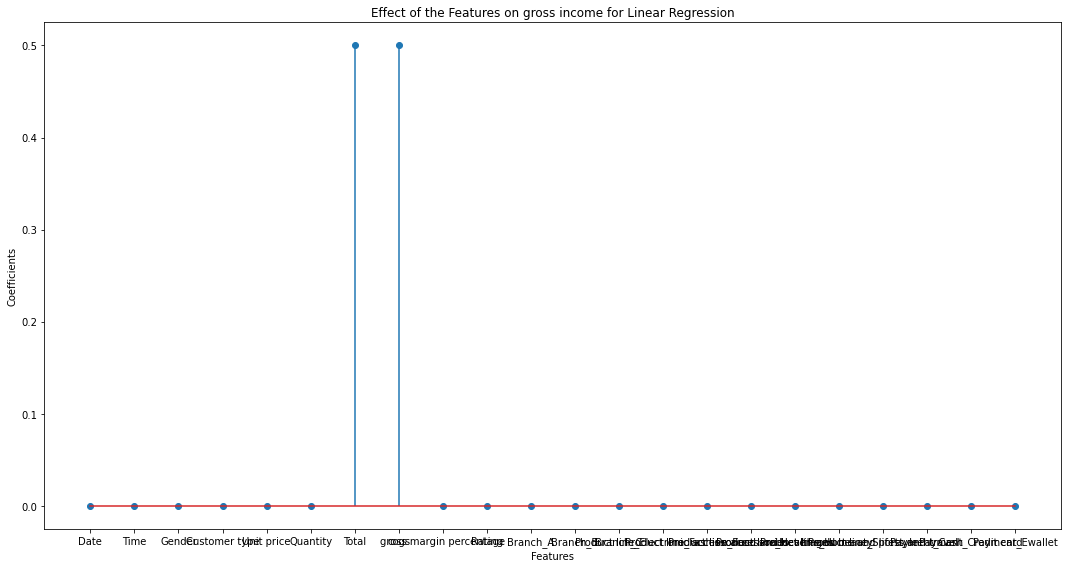

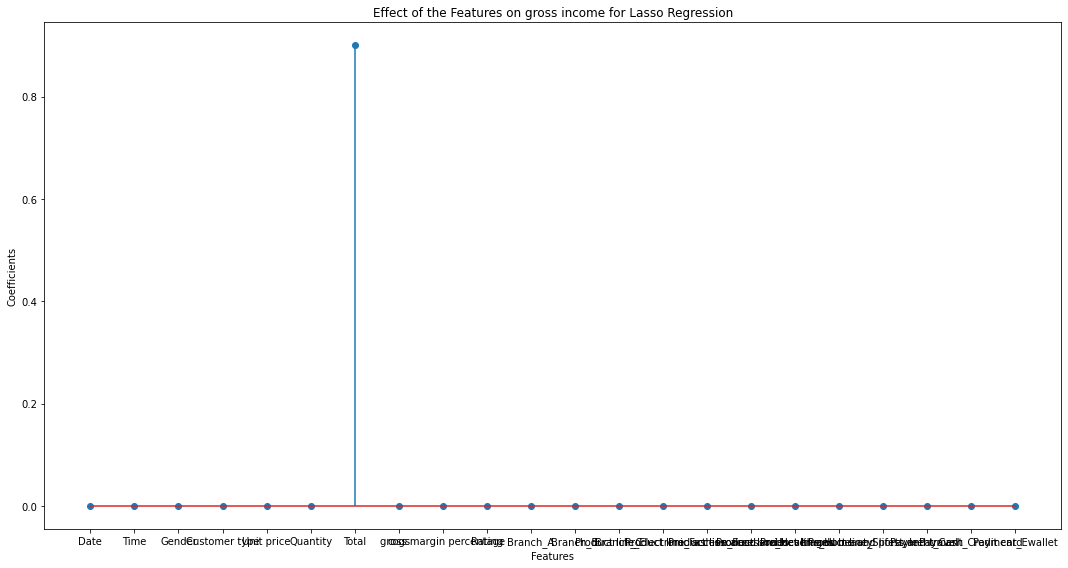

In [3]:
import matplotlib.pyplot as plt
# Plotting the coefficients
plt.figure(figsize=(15,8))
plt.stem(['Date','Time','Gender','Customer type'] + num_features_gi + onehotfeatures, lin_reg_coeff)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Effect of the Features on gross income for Linear Regression")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
plt.stem(['Date','Time','Gender','Customer type'] + num_features_gi + onehotfeatures, lasso_coeff)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Effect of the Features on gross income for Lasso Regression")
plt.tight_layout()
plt.show()

Hence the features: 'Date', 'Time', 'Gender', 'Customer type', 'Unit price', 'Quantity', 'gross margin percentage', 'Rating', 'Branch', 'Product line', and 'Payment' are excluded by the Lasso regresor. This happened because Lasso promotes sparsity and possibly these features provided less information in predicting gross income.   
Only the features 'Total' and 'cogs' contributed to predicting 'gross income'. The stem plot shows the importance of these features towards predicting gross income.

The effect of variables like unit price, and quantity on the gross income can be interpreted from the coefficients_df. Features with higher absolute values have a greater impact on the gross income. A positive coefficient indicates a direct relationship while a negative coefficient indicates an inverse relationship.

So from the table, for example, according to the Lasso Regressor, the feature Total has higher influence on gross income than cogs.

3. Train a multiple linear regression with and without Lasso regularization to **predict ```Unit price```**.

    1. How is the unit price affected by gross income, quantity, and other variables like day, timeslot, and product line in general?
    
    4. When using Lasso regularizer, which value for the hyperparameter $\lambda$ best works for this dataset? Which features were excluded in this model, if any?

In [4]:
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Splitting the features and target labels for predicting Unit Price
y_train_up = X_train_preprocessed['Unit price']
y_test_up = X_test_preprocessed['Unit price']

X_train_up = X_train_preprocessed.drop(columns=['Unit price'])
X_test_up = X_test_preprocessed.drop(columns=['Unit price'])

# Linear Regression Pipeline for predicting Unit Price
lin_reg_pipeline_up = Pipeline([('lin_reg', LinearRegression())])

# SAving the model as a pickle file
joblib.dump(lin_reg_pipeline_up, 'LinearRegressorforUnitPrice.pkl');

# Fitting the model to the training data
lin_reg_pipeline_up.fit(X_train_up, y_train_up)


#lin_reg_pipeline_up = joblib.load('LinearRegressorforUnitPrice.pkl')
# Predicting for the test set
y_pred_lin_reg = lin_reg_pipeline_up.predict(X_test_up)

lin_reg_r2 = r2_score(y_test_up, y_pred_lin_reg)
lin_reg_mae = mean_absolute_error(y_test_up, y_pred_lin_reg)
lin_reg_mse = mean_squared_error(y_test_up, y_pred_lin_reg)

# Print the regression metrics
print("For Linear Regression:")
print("R-squared (R2) Score:", lin_reg_r2)
print("Mean Absolute Error (MAE):", lin_reg_mae)
print("Mean Squared Error (MSE):", lin_reg_mse,'\n')

# Lasso Regression with Cross-Validation
# Using KFold cross-validation strategy for more robust results
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Defining the lasso pipeline
lasso_pipeline_up = Pipeline([('lasso', LassoCV(cv=kf, alphas=np.linspace(0.2,5,10)))])

# Fitting the model to the training data
lasso_pipeline_up.fit(X_train_up, y_train_up)

# Saving as pickle file
joblib.dump(lasso_pipeline_up, 'LinearRegressorforUnitPrice.pkl');

y_pred_lasso = lasso_pipeline_up.predict(X_test_up)
lasso_r2 = r2_score(y_test_up, y_pred_lasso)
lasso_mae = mean_absolute_error(y_test_up, y_pred_lasso)
lasso_mse = mean_squared_error(y_test_up, y_pred_lasso)

print("For Lasso Regression:")
print("R-squared (R2) Score:", lasso_r2)
print("Mean Absolute Error (MAE):", lasso_mae)
print("Mean Squared Error (MSE):", lasso_mse)

# Getting Linear Regression Coefficients
lin_reg_coeff = lin_reg_pipeline_up.named_steps['lin_reg'].coef_

# Getting Lasso Regression Coefficients
lasso_coeff = lasso_pipeline_up.named_steps['lasso'].coef_

# Removing the 'Unit price' feature from numerical_features
num_features_up = numerical_features[:]
num_features_up.remove('Unit price')

# Creating a DataFrame for better visualization
coefficients_df = pd.DataFrame({
    'Feature': ['Date','Time','Gender','Customer type'] + num_features_up + onehotfeatures,
    'Linear Regression Coeff': lin_reg_coeff,
    'Lasso Regression Coeff': lasso_coeff
})

display(coefficients_df)

# Getting the best alpha value for the lasso regression
best_alpha = lasso_pipeline_up.named_steps['lasso'].alpha_
print(f"Best alpha for Lasso: {best_alpha}")

# Printing the excluded Lasso features
excluded_features = coefficients_df[coefficients_df['Lasso Regression Coeff'] == 0]['Feature'].tolist()
print(f"Excluded Features by Lasso: {excluded_features}\n")

# Printing the included Lasso features
included_features = coefficients_df[coefficients_df['Lasso Regression Coeff'] != 0]['Feature'].tolist()
print(f"Included Features by Lasso: {included_features}\n")

# Calculating the 95% CI for Linear Regressor
confidence_interval = estimate_r2_CI(lin_reg_pipeline_up, X_test_up, y_test_up)
print(f"95% Confidence Interval for Linear Regression 𝑟^2 score: {confidence_interval}")

confidence_interval = estimate_r2_CI(lasso_pipeline_up, X_test_up, y_test_up)
print(f"95% Confidence Interval for Lasso 𝑟^2 score: {confidence_interval}")

For Linear Regression:
R-squared (R2) Score: 0.7927873218495987
Mean Absolute Error (MAE): 0.3545071895171906
Mean Squared Error (MSE): 0.21542405812873308 

For Lasso Regression:
R-squared (R2) Score: 0.4913334469799068
Mean Absolute Error (MAE): 0.6156649931201509
Mean Squared Error (MSE): 0.5288238830946773


,Feature,Linear Regression Coeff,Lasso Regression Coeff
0,Date,-0.004792,-0.000000e+00
1,Time,0.021095,0.000000e+00
2,Gender,0.019647,0.000000e+00
3,Customer type,-0.067488,-0.000000e+00
4,Quantity,-0.857272,-1.840399e-01
5,Total,0.414049,5.638319e-01
6,cogs,0.414049,3.197442e-16
7,gross margin percentage,0.000000,0.000000e+00
8,gross income,0.414049,0.000000e+00
9,Rating,0.015859,-0.000000e+00


Best alpha for Lasso: 0.2
Excluded Features by Lasso: ['Date', 'Time', 'Gender', 'Customer type', 'gross margin percentage', 'gross income', 'Rating', 'Branch_A', 'Branch_B', 'Branch_C', 'Product line_Electronic accessories', 'Product line_Fashion accessories', 'Product line_Food and beverages', 'Product line_Health and beauty', 'Product line_Home and lifestyle', 'Product line_Sports and travel', 'Payment_Cash', 'Payment_Credit card', 'Payment_Ewallet']

Included Features by Lasso: ['Quantity', 'Total', 'cogs']

95% Confidence Interval for Lasso 𝑟^2 score: [0.74759488 0.83056175]
95% Confidence Interval for Lasso 𝑟^2 score: [0.4099563  0.55255827]


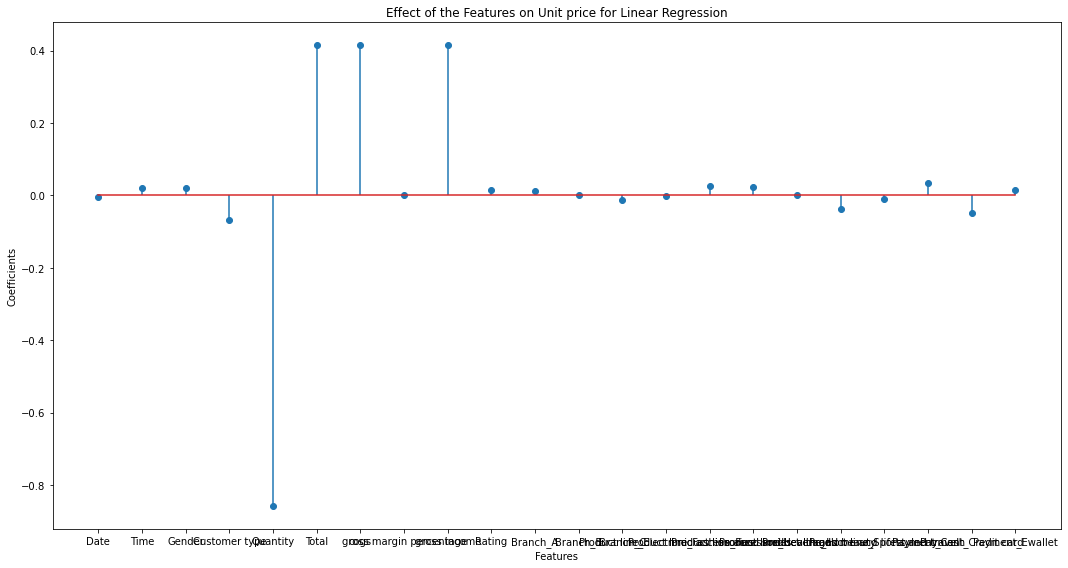

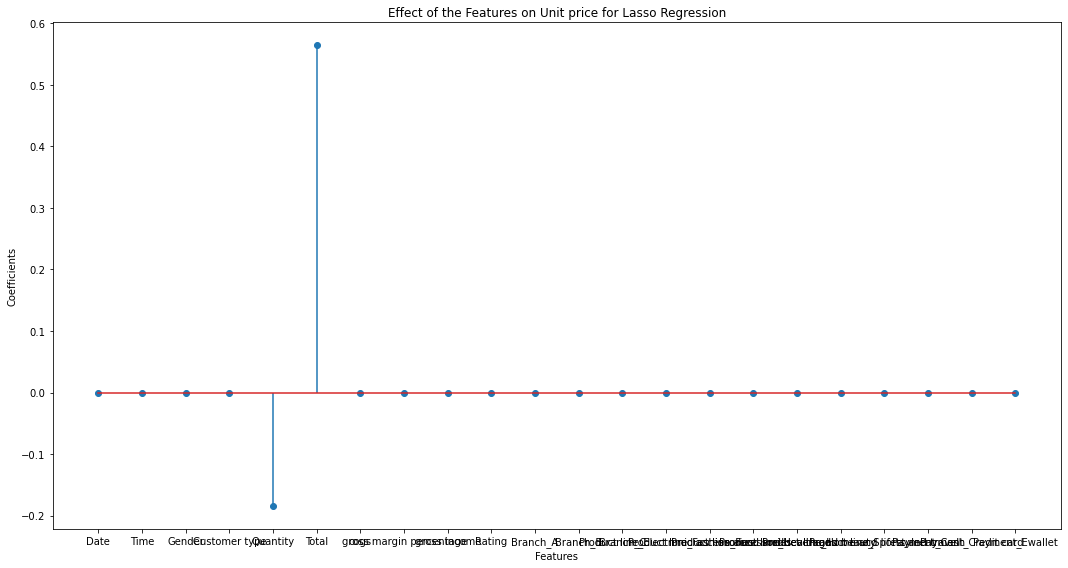

In [5]:
import matplotlib.pyplot as plt
# Plotting the coefficients
plt.figure(figsize=(15,8))
plt.stem(['Date','Time','Gender','Customer type'] + num_features_up + onehotfeatures, lin_reg_coeff)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Effect of the Features on Unit price for Linear Regression")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
plt.stem(['Date','Time','Gender','Customer type'] + num_features_up + onehotfeatures, lasso_coeff)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Effect of the Features on Unit price for Lasso Regression")
plt.tight_layout()
plt.show()

Again, the effect of variables on the unit proce can be interpreted from the coefficients_df or the stem plot shown. Features with higher absolute values have a greater impact on the gross income. A positive coefficient indicates a direct relationship while a negative coefficient indicates an inverse relationship.

So from the table (or the stem plot), for example, according to the Lasso Regressor, the feature Total has higher positve influence on unit price and Quantity has higher negative effect on unit price.

---

#### Question 4 and 5 are required for completion for the EEL 5934 section only. Individuals in EEL 4930 are welcome to solve these tasks but no extra credit will be credited.

4. Train a logistic regression to **classify gender** and study the relationship between attributes. Namely, explain the relationship between gender, product line, payment and gross income for branch C. To study this relationship, consider all the interaction attribution of degree 2. (See ```interaction_only``` variable in [```PolynomialFeatures```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)).

    1. For ```Gender=male``` customers, plot the parameters values for all attributes (and its 2nd-order interactions).
    2. Which attributes are the most informative?

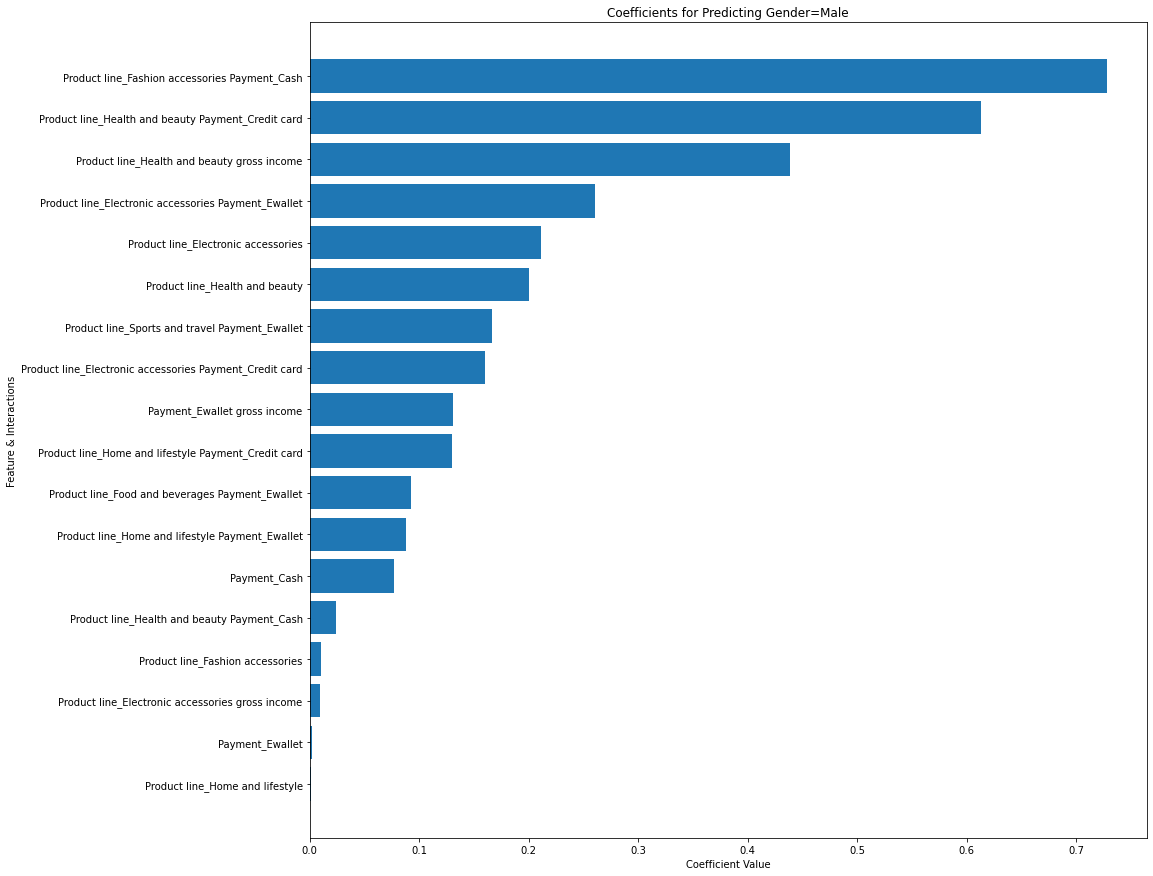

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Filtering the data for branch 'C'
train_data_branch_C = X_train_preprocessed[X_train_preprocessed['Branch_C'] == 1]
test_data_branch_C = X_test_preprocessed[X_test_preprocessed['Branch_C'] == 1]

# Splitting the data for interaction and training logistic regression to classify Gender
X_train_g = train_data_branch_C.drop(columns=['Gender'])
# Only including Product Line, Payment and gross income for interaction
X_train_g_int = train_data_branch_C[['Product line_Electronic accessories', 'Product line_Fashion accessories',
                                 'Product line_Food and beverages','Product line_Health and beauty',
                                 'Product line_Home and lifestyle', 'Product line_Sports and travel',
                                 'Payment_Cash','Payment_Ewallet', 'Payment_Credit card', 'gross income']]
y_train_g = train_data_branch_C['Gender']

X_test_g = test_data_branch_C.drop(columns=['Gender'])
# Only including Product Line, Payment and gross income for interaction
X_test_g_int = test_data_branch_C[['Product line_Electronic accessories', 'Product line_Fashion accessories',
                                 'Product line_Food and beverages','Product line_Health and beauty',
                                 'Product line_Home and lifestyle', 'Product line_Sports and travel',
                                 'Payment_Cash','Payment_Ewallet', 'Payment_Credit card', 'gross income']]
y_test_g = test_data_branch_C['Gender']


# Defining and fitting the interaction attribution with degree 2
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction = interaction.fit_transform(X_train_g_int)

feature_names = interaction.get_feature_names_out()


# Training a logistic regression model to find out the relationship
logistic_model_g_int = LogisticRegression(max_iter=10000)
logistic_model_g_int.fit(X_train_interaction, y_train_g)

# Getting the coefficients from the trained Logistic regression model
coefficients_logreg = logistic_model_g_int.coef_[0]

# Creating a DataFrame for better visualization
coefficients_df = pd.DataFrame({'Feature': feature_names,
                                'Coefficient': coefficients_logreg})

# Filtering for Gender=Male
coefficients_df_male = coefficients_df[coefficients_df['Coefficient'] > 0]

coefficients_df_male = coefficients_df_male.sort_values(by='Coefficient', ascending=False)

# Plotting the feature combinations that influence in gender being Male
plt.figure(figsize=(15, 15))
plt.barh(coefficients_df_male['Feature'], coefficients_df_male['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Features & Interactions')
plt.title('Coefficients for Predicting Gender=Male')
plt.gca().invert_yaxis()
plt.show()

From the plotted bar chart, we can see the magnitude and direction of each coefficient. The attributes with the highest coefficients are the most informative when predicting gender (being Male). Interaction terms with significant coefficients indicate that the relationship between the two features has a considerable effect on predicting gender being Male.   
Hence, from the above plot, it is clear that the chances of Gender being Male is highest when the Product line is Fashion Accessories and Payment is Cash. Seems like gross income has little influence on the gender being male.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, classification_report
from sklearn.pipeline import Pipeline
import numpy as np
from scipy import stats

# Defining a custom R^2 scorer for logistic regression
def logistic_r2_estimator(y_true, y_pred_prob):
    return np.square(np.corrcoef(y_true, y_pred_prob)[0, 1])

r2_scorer = make_scorer(logistic_r2_estimator, greater_is_better=True, needs_proba=True)

# Creating a pipeline with Logistic Regression with interaction
pipeline = Pipeline([
    ("interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("logreg", LogisticRegression(max_iter=10000))
])

# Defining hyperparameters to tune
param_grid = {'logreg__C': np.linspace(-3, 3, 7)}

# Implementing GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring=r2_scorer, cv=5, n_jobs=-1)

# FItting the model to the training data
grid_search.fit(X_train_g, y_train_g)

# Getting the best model and parameters
best_params = grid_search.best_params_
best_r2 = grid_search.best_score_

print(f"Best C (inverse regularization strength): {best_params['logreg__C']}\n")

# Saving as pickle file
joblib.dump(grid_search.best_estimator_, 'LogRegforGender.pkl');

r2_scores = cross_val_score(grid_search.best_estimator_, X_test_g, y_test_g, cv=5, scoring=r2_scorer)
print(classification_report(y_test_g, grid_search.best_estimator_.predict(X_test_g)))

confidence_level = 0.95
degrees_freedom = len(r2_scores) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, loc=np.mean(r2_scores), scale=stats.sem(r2_scores))

print(f"R^2 (coefficient of determination): {best_r2:.4f}")
print(f"95% confidence interval for R^2: ({confidence_interval[0]:.4f}, {confidence_interval[1]:.4f})")

Best C (inverse regularization strength): 1.0

              precision    recall  f1-score   support

         0.0       0.62      0.67      0.64        42
         1.0       0.50      0.45      0.47        31

    accuracy                           0.58        73
   macro avg       0.56      0.56      0.56        73
weighted avg       0.57      0.58      0.57        73

R^2 (coefficient of determination): 0.0218
95% confidence interval for R^2: (-0.0396, 0.2096)


5. Train a logistic regression to **classify customer type** and study the relationship between attributes. Namely, explain the relationship between customer type, gender, day and timeslot for branch C. To study this relationship, consider all the interaction attribution of degree 2. (See ```interaction_only``` variable in [```PolynomialFeatures```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)).

    1. For ```Customer type = Normal``` customers, plot the parameters values for all attributes (and its 2nd-order interactions).
    2. Which attributes are the most informative?

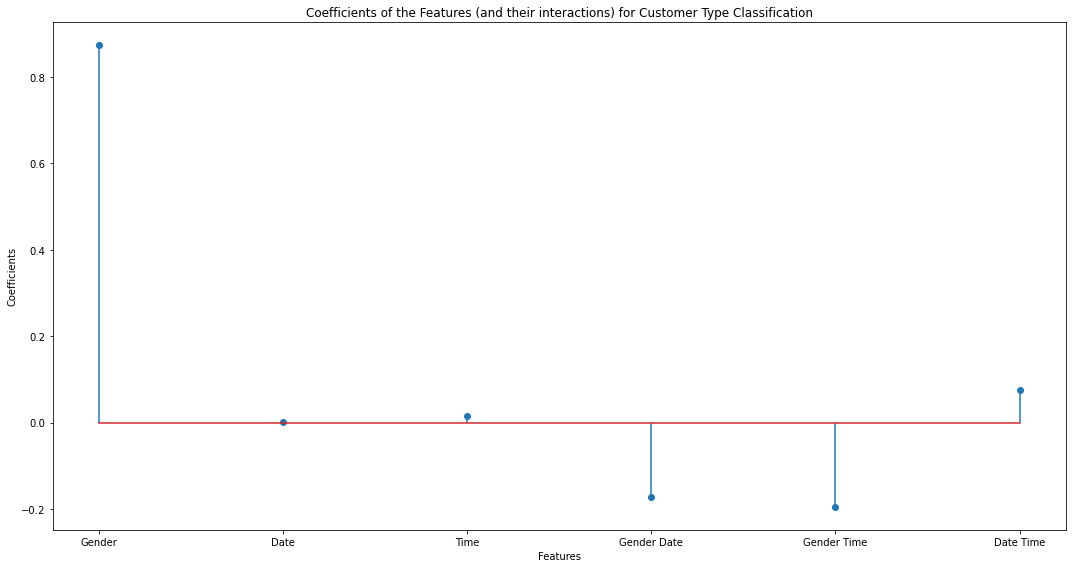

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Filtering the data for branch 'C'
train_branch_c_data = X_train_preprocessed[X_train_preprocessed['Branch_C'] == 1]
test_branch_c_data = X_test_preprocessed[X_train_preprocessed['Branch_C'] == 1]

# Define X and y for training and test
X_train_ct = train_branch_c_data.drop(columns=['Customer type'])
X_train_ct_int = train_branch_c_data[['Gender', 'Date', 'Time']]
y_train_ct = train_branch_c_data['Customer type']

X_test_ct = test_branch_c_data.drop(columns=['Customer type'])
X_test_ct_int = test_branch_c_data[['Gender', 'Date', 'Time']]
y_test_ct = test_branch_c_data['Customer type']

# Creating a pipeline
logreg_pipeline = Pipeline([("interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                            ("logreg", LogisticRegression(max_iter=10000))])

# FItting the model with interaction
logreg_pipeline.fit(X_train_ct_int, y_train_ct)

# Getting the coefficients from the logistic regression model
coefficients = logreg_pipeline.named_steps['logreg'].coef_[0]

# Generating the feature names from PolynomialFeatures
feature_names = logreg_pipeline.named_steps['interaction'].get_feature_names_out()

# Plotting the coefficients
plt.figure(figsize=(15,8))
plt.stem(feature_names, coefficients)
#plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Coefficients of the Features (and their interactions) for Customer Type Classification")
plt.tight_layout()
plt.show()

Attributes with large positive coefficients indicate a strong positive relationship with the "Normal" customer type.
Attributes with large negative coefficients indicate a strong negative relationship with the "Normal" customer type.
Features with coefficients furthest away from 0 (whether positive or negative) have the strongest impact on the prediction.

From the plotted coefficients, it is apparent that Gender atribute is more impactful on the Customer type being Normal.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

# Defining the pipeline for logistic regression with interaction
pipeline = Pipeline([
    ("interaction", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("logreg", LogisticRegression(max_iter=10000))
])

# Defining the hyperparameters to search over
param_grid = {"logreg__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "logreg__penalty": ["l1", "l2"],
              "logreg__solver": ["liblinear", "saga"]}

# Defining the GridSearchCV attribute
logreg_ct = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

# Fitting the model to the training data
logreg_ct.fit(X_train_ct, y_train_ct)

# Printing the best parameters
print("Best hyperparameters:", logreg_ct.best_params_)

print(classification_report(logreg_ct.best_estimator_.predict(X_test_ct), y_test_ct))

# Calculating the confidence interval for R^2
logreg_ct_r2_scores = cross_val_score(logreg_ct.best_estimator_,
                                      X_test_ct, y_test_ct, cv=5, scoring=r2_scorer)

confidence_level = 0.95
degrees_freedom = len(logreg_ct_r2_scores) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom,
                                       loc=np.mean(logreg_ct_r2_scores), scale=stats.sem(logreg_ct_r2_scores))

print(f"R^2: {np.mean(logreg_ct_r2_scores):.4f}")
print(f"95% Confidence Interval for R^2: {confidence_interval}")

Best hyperparameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64        46
         1.0       0.33      0.39      0.36        23

    accuracy                           0.54        69
   macro avg       0.50      0.50      0.50        69
weighted avg       0.56      0.54      0.54        69

R^2: 0.1208
95% Confidence Interval for R^2: (0.001811175132875542, 0.2397186038528208)


---

For what follows, use accuracy as one of your metrics of success and report its 95% confidence interval. Carry any necessary hyperparameter tuning with pipelines. Choose the best CV strategy and report on the best hyperparameter settings.

6. Train a classifier to **predict the day of purchase** (Monday, Tuesday, etc.).

    1. Select at least 2 classifiers.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Splitting the data into features and target for day of purchase Classification
y_train_day = X_train_preprocessed['Date']
X_train_day = X_train_preprocessed.drop(columns=['Date'])

y_test_day = X_test_preprocessed['Date']
X_test_day = X_test_preprocessed.drop(columns=['Date'])

# Defining Pipeline for Logistic Regression
logreg_pipeline = Pipeline([("logreg", LogisticRegression(max_iter=10000))])

# Definig the hyperparameters grid for Logistic Regression Gridsearch
logreg_params = {"logreg__C": [0.001, 0.01, 0.1, 1, 10, 100],
                 "logreg__penalty": ["l1", "l2"],
                 "logreg__solver": ["liblinear", "saga"]}

logreg_day = GridSearchCV(logreg_pipeline, logreg_params, cv=5, n_jobs=-1, scoring='accuracy')
logreg_day.fit(X_train_day, y_train_day)

# Printing the best parameters for Logistic Regression
print("Logistic Regression - Best hyperparameters:", logreg_day.best_params_)


# Defining the pipeline for Random Forest Classifier
rf_pipeline = Pipeline([("rf", RandomForestClassifier())])

# Definig the hyperparameters grid for Random Forest Classifier Gridsearch
rf_params = {"rf__n_estimators": [10, 25, 50, 100, 150],
             "rf__max_depth": [None, 5, 10, 20, 30],
             "rf__min_samples_split": [1, 2, 5, 10, 15],
             "rf__min_samples_leaf": [1, 2, 4, 6]}

rf_day = GridSearchCV(rf_pipeline, rf_params, cv=5, n_jobs=-1, scoring='accuracy')
rf_day.fit(X_train_day, y_train_day)

# Priniting the best parameters for Random Forest Classifier
print("Random Forest Classifier - Best hyperparameters:", rf_day.best_params_)


# For Logistic Regression
logreg_r2_scores = cross_val_score(logreg_day.best_estimator_,
                                   X_test_day, y_test_day, cv=5, scoring=r2_scorer)

confidence_level = 0.95
degrees_freedom = len(logreg_r2_scores) - 1
logreg_confidence_interval = stats.t.interval(confidence_level, degrees_freedom,
                                       loc=np.mean(logreg_r2_scores), scale=stats.sem(logreg_r2_scores))
logreg_confidence_interval = estimate_r2_CI(logreg_day.best_estimator_,X_test_day, y_test_day)

if np.mean(logreg_r2_scores is not float):
    print("Logistic Regression R^2: ", r2_score(y_test_day, logreg_day.best_estimator_.predict(X_test_day)))
else:
    print(f"Logistic Regression R^2: {np.mean(logreg_r2_scores):.4f}")
print(f"95% Confidence Interval for Logistic Regression R^2: {logreg_confidence_interval}\n")
print(classification_report(y_test_day, logreg_day.best_estimator_.predict(X_test_day)))

# For Random Forest Classifier
rf_r2_scores = cross_val_score(rf_day.best_estimator_,
                               X_test_day, y_test_day, cv=5, scoring=r2_scorer)

confidence_level = 0.95
degrees_freedom = len(rf_r2_scores) - 1
rf_confidence_interval = stats.t.interval(confidence_level, degrees_freedom,
                                          loc=np.mean(rf_r2_scores), scale=stats.sem(rf_r2_scores))
rf_confidence_interval = estimate_r2_CI(rf_day.best_estimator_,X_test_day, y_test_day)

if np.mean(rf_r2_scores is not float):
    print("Random Forest R^2: ", r2_score(y_test_day, rf_day.best_estimator_.predict(X_test_day)))
else:
    print(f"Random Forest R^2: {np.mean(rf_r2_scores):.4f}")
print(f"95% Confidence Interval for Random Forest Classifier R^2: {rf_confidence_interval}\n")
print(classification_report(y_test_day, rf_day.best_estimator_.predict(X_test_day)))

Logistic Regression - Best hyperparameters: {'logreg__C': 0.01, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Random Forest Classifier - Best hyperparameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 15, 'rf__n_estimators': 50}
-0.22840739047952963
95% Confidence Interval for Logistic Regression R^2: [-0.39987463 -0.12066052]

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        26
         1.0       0.00      0.00      0.00        36
         2.0       0.14      1.00      0.25        28
         3.0       0.00      0.00      0.00        25
         4.0       0.00      0.00      0.00        29
         5.0       0.00      0.00      0.00        28
         6.0       0.00      0.00      0.00        28

    accuracy                           0.14       200
   macro avg       0.02      0.14      0.04       200
weighted avg       0.02      0.14      0.03       200

-0.7868882224406613
95% Confide

---

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

---